In [56]:
import pandas as pd
from datetime import datetime
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [57]:
time_interval = '29T' # we group trades on 15 minutes intervals
N = 10 # number of days
T = 100 # number of stocks

Load the train and val files, merge them, keep only data before 4pm and add a log return column

In [58]:

train_file = f"data/train_data_N{N}_T{T}_2012.parquet"
val_file = f"data/val_data_N{N}_T{T}_2012.parquet"
train_df = pd.read_parquet(train_file)
val_df = pd.read_parquet(val_file)

combined_df = pd.concat([train_df, val_df], ignore_index=True)

time_threshold = "16:00"
time_limit = pd.to_datetime(time_threshold, format="%H:%M").time()
filtered_df = combined_df[combined_df['Time_of_day'] <= time_limit]
filtered_df["Date"] = filtered_df["Timestamp"].dt.date

filtered_df['log-return'] = np.log(filtered_df['trade-price']).diff()
filtered_df = filtered_df.dropna(subset=['log-return'])
filtered_df.head()

ArrowMemoryError: realloc of size 33554432 failed

In [42]:
x = filtered_df
x['Floored_Timestamp'] = x['Timestamp'].dt.floor('1T') # Floor the timestamp to the nearest time_interval minutes
x2 = x[(x['Stock'] == 'XLY.P') & (x['Floored_Timestamp'].dt.time == datetime.strptime('12:00', '%H:%M').time())]
x2.sort_values(by='Floored_Timestamp', inplace=True)
x2

C:\Users\phlev\AppData\Local\Temp\ipykernel_111988\2424413440.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x2.sort_values(by='Floored_Timestamp', inplace=True)


,trade-price,trade-volume,trade-stringflag,trade-rawflag,Timestamp,Stock,Time_of_day,Before_16:00,Date,log-return,Floored_Timestamp
92022,44.45,100,marketclosed|volumeupdate,[GV4_TEXT] FT [IRGCOND]1265[PRC_QL2]NBL,2012-03-20 12:00:04.017,XLY.P,12:00:04.017000,True,2012-03-20,0.003380,2012-03-20 12:00:00
153526,45.63,100,marketclosed|volumeupdate,[GV4_TEXT] FT [IRGCOND]1265,2012-04-27 12:00:24.053,XLY.P,12:00:24.053000,True,2012-04-27,0.002853,2012-04-27 12:00:00
3093756,45.63,1900,marketclosed|volumeupdate,[GV4_TEXT] FT [IRGCOND]1265,2012-04-27 12:00:24.053,XLY.P,12:00:24.053000,True,2012-04-27,0.003293,2012-04-27 12:00:00
170938,45.63,380,marketclosed|volumeupdate,[GV4_TEXT] T [IRGCOND]132[PRC_QL2]NBL,2012-05-07 12:00:00.516,XLY.P,12:00:00.516000,True,2012-05-07,0.013681,2012-05-07 12:00:00
172556,44.90,160,marketclosed|volumeupdate,[GV4_TEXT] FT [IRGCOND]1265[PRC_QL2]NBL,2012-05-08 12:00:05.701,XLY.P,12:00:05.701000,True,2012-05-08,0.013453,2012-05-08 12:00:00


Create the dataframe: basically a table with each columns as days, each row as a stock logreturn on a designated interval

In [43]:

filtered_df['Floored_Timestamp'] = filtered_df['Timestamp'].dt.floor(time_interval) # Floor the timestamp to the nearest time_interval minutes
# add a column with stock and new timestamp for merging
filtered_df['Stock_Timestamp'] = filtered_df['Stock'] + "_" + filtered_df['Floored_Timestamp'].dt.strftime('%H:%M:%S')

grouped_df = filtered_df.pivot_table(index='Stock_Timestamp', columns='Date', values='log-return', aggfunc='mean')
grouped_df = grouped_df.fillna(0)

print(grouped_df.shape)
grouped_df


(2033, 100)


Date,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-09,2012-01-10,2012-01-11,2012-01-12,2012-01-13,2012-01-17,...,2012-05-11,2012-05-14,2012-05-15,2012-05-16,2012-05-17,2012-05-18,2012-05-21,2012-05-22,2012-05-23,2012-05-24
Stock_Timestamp,,,,,,,,,,,,,,,,,,,,,
XLB.P_11:23:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XLB.P_11:24:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XLB.P_11:31:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XLB.P_11:32:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XLB.P_11:35:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XLY.P_15:55:00,-0.000073,0.000591,-0.000062,0.002669,0.000000,-0.000869,0.000786,-0.002982,0.001496,0.000000,...,0.003543,-0.000114,0.002314,-0.000786,-0.004190,-0.004477,0.001687,0.003065,-0.000506,-0.000470
XLY.P_15:56:00,0.000235,0.001955,0.000508,0.000000,-0.000250,0.000496,-0.000248,-0.000498,0.000000,-0.000566,...,0.003826,0.000000,0.004452,-0.000091,0.000000,-0.005773,0.004031,0.008600,-0.002941,-0.000661
XLY.P_15:57:00,-0.000377,-0.000253,0.001526,0.002921,0.000000,0.000373,0.000497,0.000000,0.000000,-0.000514,...,0.000000,0.000895,0.005473,0.000916,-0.006220,-0.005014,0.003084,0.000929,-0.003772,-0.000167


In [ ]:
#create correlation dataframe between days
corr = grouped_df.corr()
corr.head()

Date,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-09,2012-01-10,2012-01-11,2012-01-12,2012-01-13,2012-01-17,...,2012-05-11,2012-05-14,2012-05-15,2012-05-16,2012-05-17,2012-05-18,2012-05-21,2012-05-22,2012-05-23,2012-05-24
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,-0.023610,0.004567,0.002750,0.005945,0.011926,0.003006,-0.013853,-0.018142,-0.014415,...,0.008246,0.014982,-0.004946,-0.037218,-0.008776,-0.001304,0.003349,0.003810,-0.001181,0.000162
2012-01-04,-0.023610,1.000000,-0.073870,-0.026306,-0.148662,-0.145068,-0.084906,0.299340,0.252114,0.168442,...,-0.062002,-0.176904,-0.001509,0.161873,0.133417,0.284035,0.007793,0.062323,-0.004199,0.081526
2012-01-05,0.004567,-0.073870,1.000000,0.211645,0.273205,0.189749,0.159832,-0.052220,-0.072555,-0.098868,...,0.018440,0.047363,-0.074245,-0.030153,-0.042035,-0.005550,-0.025708,-0.027334,0.097303,0.071520
2012-01-06,0.002750,-0.026306,0.211645,1.000000,0.044068,0.035525,0.061967,0.036182,0.094234,-0.037052,...,-0.150341,-0.017377,0.098287,0.073440,-0.129741,-0.132708,-0.166488,-0.210219,0.146352,-0.052391
2012-01-09,0.005945,-0.148662,0.273205,0.044068,1.000000,0.061809,0.020079,-0.128263,-0.151790,-0.162685,...,0.053673,-0.023330,-0.233495,-0.173938,0.009771,0.057706,0.034812,-0.015625,0.150219,0.035317


In [45]:

def get_sortest_eig(C):
    '''
    input 
        C: correlation matrix
        
    output: 
        l: eigenvalues
        v: eigenvectors 
    '''
    
    l,v = np.linalg.eigh(C)
    ordn = np.argsort(l)
    l,v = l[ordn],v[:,ordn]
    return l,v

l, v = get_sortest_eig(corr)

lambda_limit = 1e-1
len(l[l<lambda_limit]) 
selected_indices = [i for i, l in enumerate(l) if l <= lambda_limit]

C_r = np.zeros_like(corr)

for i in selected_indices:
    v_i = v[:, i]  # Get the i-th eigenvector
    outer_product = np.outer(v_i, v_i)  # Compute outer product
    C_r += l[i] * outer_product  # Add scaled matrix to the sum

C_m = l[-1] * np.outer(v[-1, :],v[-1, :])
C_0 = C_r + C_m
C = abs(corr - C_0)
G = nx.from_pandas_adjacency(C)


In [46]:
partition = community_louvain.best_partition(G)
print(len(partition))
print(partition)

100
{datetime.date(2012, 1, 3): 4, datetime.date(2012, 1, 4): 0, datetime.date(2012, 1, 5): 2, datetime.date(2012, 1, 6): 2, datetime.date(2012, 1, 9): 0, datetime.date(2012, 1, 10): 0, datetime.date(2012, 1, 11): 2, datetime.date(2012, 1, 12): 0, datetime.date(2012, 1, 13): 0, datetime.date(2012, 1, 17): 0, datetime.date(2012, 1, 18): 0, datetime.date(2012, 1, 19): 2, datetime.date(2012, 1, 20): 4, datetime.date(2012, 1, 23): 0, datetime.date(2012, 1, 24): 0, datetime.date(2012, 1, 25): 2, datetime.date(2012, 1, 26): 0, datetime.date(2012, 1, 27): 4, datetime.date(2012, 1, 30): 4, datetime.date(2012, 1, 31): 0, datetime.date(2012, 2, 1): 0, datetime.date(2012, 2, 2): 0, datetime.date(2012, 2, 3): 0, datetime.date(2012, 2, 6): 2, datetime.date(2012, 2, 7): 2, datetime.date(2012, 2, 8): 4, datetime.date(2012, 2, 9): 4, datetime.date(2012, 2, 10): 4, datetime.date(2012, 2, 13): 0, datetime.date(2012, 2, 14): 0, datetime.date(2012, 2, 15): 4, datetime.date(2012, 2, 16): 0, datetime.date(2

In [47]:
# Convert partition to a dataframe
partition_df = pd.DataFrame(list(partition.items()), columns=['Date', 'Cluster'])

# Merge log return data with cluster assignments
log_return_clustered = filtered_df.merge(partition_df, on='Date')
log_return_clustered.groupby('Cluster')["log-return"].sum()


Cluster
0    1.172743
1    0.325779
2    0.068027
3   -0.160397
4   -1.515265
Name: log-return, dtype: float64

In [48]:
# how many clusters
num_clusters = len(set(partition.values()))
num_clusters

5

C:\Users\phlev\AppData\Local\Temp\ipykernel_111988\1841700985.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


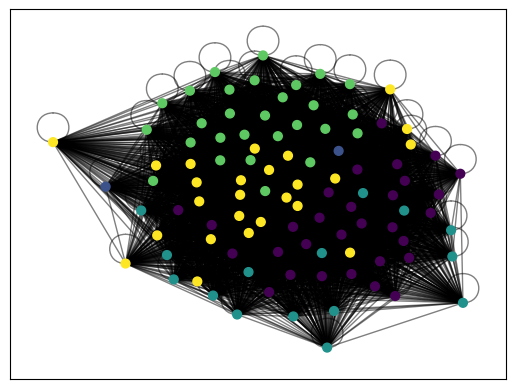

In [49]:
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()